Téléchargement de la base

In [3]:
!wget https://www.dropbox.com/s/sbiotru4wlr3ykj/train.csv.zip?dl=0 -O train.csv.zip

!unzip train.csv.zip

--2021-04-06 13:56:34--  https://www.dropbox.com/s/sbiotru4wlr3ykj/train.csv.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sbiotru4wlr3ykj/train.csv.zip [following]
--2021-04-06 13:56:35--  https://www.dropbox.com/s/raw/sbiotru4wlr3ykj/train.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc60b727e600e58f80bfeb231ee8.dl.dropboxusercontent.com/cd/0/inline/BMEZZqOCQ3rCWVVoTiIyuaLpL4eIpl5v5G2L6XPfswbnjWah1C9eP4RdknHKAAgfj8o1savWNs1TflSxwqgZ0nXk7g3-zYahRObBQJcJG_2qESDPf6eaupQKIPfgMLo3mS0FU3pWk_0tuxPqy7-D4cP4/file# [following]
--2021-04-06 13:56:35--  https://uc60b727e600e58f80bfeb231ee8.dl.dropboxusercontent.com/cd/0/inline/BMEZZqOCQ3rCWVVoTiIyuaLpL4eIpl5v5G2L6XPfswbnjWah1C9eP4RdknHKAAgfj8o1savWNs1TflSxwq

Imports

In [4]:
!pip install transformers

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer
import pandas as pd
from torch.utils.data import DataLoader

if torch.cuda.is_available():    
    print("Using GPU")
    device = torch.device("cuda")

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Using GPU


## Présentation de la base

In [6]:
df = pd.read_csv('train.csv')
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


Class imbalance :

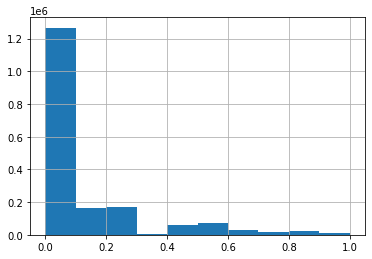

In [8]:
df['target'].hist()

D'apres kaggle, la baseline est "mauvais commentaire $\Leftrightarrow$ toxic $\ge$ 0.5", donc grosse class unbalance

La base est giganteque donc pour les premiers essais je garde que les phrases de toxitié non nulle et j'en prends 10.000

In [22]:
# n = nombre de phrases a prendre (trop long pour faire les tests)
df = df[df['target'] > 0].sample(n=10000)

In [115]:
sentences = df.comment_text.values
labels = df.target.values

Preprocessing des phrases

In [13]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Tokenisation selon les normes de BERT (avec l'option add_special_tokens qui met les BOS/EOS) 

In [117]:
inputs = []
from tqdm import tqdm
for sentence in tqdm(sentences, position=0):
    encoded_sent = tokenizer.encode(sentence,                  
                                    add_special_tokens = True, 
                                    )
    
    inputs.append(encoded_sent)

100%|██████████| 10000/10000 [00:17<00:00, 574.62it/s]


In [25]:
print('Max sentence length: ', max([len(sen) for sen in inputs]))

Max sentence length:  326


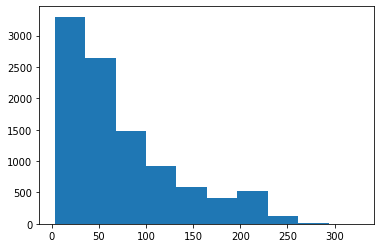

In [118]:
from matplotlib import pyplot as plt
sizes = [len(sen) for sen in inputs]
plt.hist(sizes);

In [122]:
import numpy as np
inputs_idx = np.argwhere(np.array(sizes) < 150)
clean_inputs = []
clean_labels = []

for i, input in enumerate(inputs):
    if sizes[i] < 150:
        clean_inputs.append(input)
        clean_labels.append(labels[i])

In [125]:
print('Max sentence length: ', max([len(sen) for sen in clean_inputs]))

Max sentence length:  149


In [138]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 149
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

clean_inputs = pad_sequences(clean_inputs, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\Done.')


Padding/truncating all sentences to 149 values...
\Done.


In [139]:
attention_masks = []

for sent in clean_inputs:    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_masks.append(att_mask)

In [140]:
from sklearn.model_selection import train_test_split
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(clean_inputs, clean_labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, clean_labels,
                                             random_state=2018, test_size=0.1)

In [141]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [142]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [143]:
import torch.nn.functional as F

class ToxicPredictor(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(ToxicPredictor, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        #we append an extra layer for predicting toxicity (it will be randomly initialized)
        self.fc1 = nn.Linear(self.encoder.pooler.dense.out_features, 100)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        # see in the hugging face doc what to input
        #cont_reps = #  self.encoder(..)..
        cont_reps = self.encoder(seq, attention_mask = attn_masks)
        #Obtaining the representation of [CLS] head
        pool = cont_reps["pooler_output"]

        x = F.relu(self.fc1(pool))
        pred = F.sigmoid(self.fc2(x))

        return pred


In [144]:
import gc
del model
gc.collect()

23367

In [145]:
model = ToxicPredictor('bert-base-uncased').to(device)

In [146]:
model.encoder.requires_grad_ = False

In [150]:
import torch.nn as nn
import torch.optim as optim
# define the loss and optimizer 
criterion = nn.MSELoss()
opti = optim.Adam(model.parameters(), lr = 1e-4)

In [151]:
def train(model, criterion, opti, train_loader, val_loader, epochs=1, print_every=1, validate_every=1):
    for epoch in range(epochs):
        tot_loss = 0
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            #Clear gradients
            opti.zero_grad()  
            #Converting these to cuda tensors
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            
            preds = model(seq, attn_masks)

            #Computing loss
            loss = criterion(preds, labels.float())

            #Backpropagating the gradients
            loss.backward()
            tot_loss += loss.item()

            #Optimization step
            opti.step()

            if (it + 1) % print_every == 0:
                print("loss :", tot_loss)
                tot_loss = 0   

        if ep % validate_every==0:
            loss_val = 0
            for it, (seq, attn_masks, labels) in enumerate(val_loader):            
                seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
                #Obtaining the logits from the model
                preds_val = model(seq, attn_masks)
            
                loss = float(criterion(preds_val.squeeze(-1), labels.float()))
  
                loss_val += loss_val.item()
            print("loss val :", loss_val)   

In [152]:
train(model, criterion, opti, train_dataloader, validation_dataloader, print_every=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss : 0.2635061666369438
loss : 0.2209712155163288
loss : 0.20888319984078407
loss : 0.2889014631509781
loss : 0.23915118537843227
loss : 0.2387375645339489
loss : 0.26026493683457375
loss : 0.22493534535169601
loss : 0.23696331307291985
loss : 0.25286702811717987
loss : 0.19760411605238914
loss : 0.25766223669052124
loss : 0.2306320108473301
loss : 0.2507226765155792
loss : 0.2522345930337906
loss : 0.2599559649825096
loss : 0.3097842261195183
loss : 0.20434489846229553
loss : 0.2510543577373028
loss : 0.29240112006664276
loss : 0.23521188646554947
loss : 0.2774582765996456
loss : 0.26143964007496834
loss : 0.18956414237618446
loss : 0.26551034674048424
loss : 0.29058102518320084
loss : 0.2389667071402073
loss : 0.25917237251996994
loss : 0.2524183467030525
loss : 0.24915490671992302
loss : 0.23582366108894348
loss : 0.2206057384610176
loss : 0.23725293576717377
loss : 0.18961792439222336
loss : 0.267345130443573
loss : 0.28856081888079643
loss : 0.253738209605217
loss : 0.2518665455

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NameError: ignored